# Assignment 7

Train a Transformer model for Machine Translation from Russian to English.  
Dataset: http://data.statmt.org/wmt18/translation-task/training-parallel-nc-v13.tgz   
Make all source and target text to lower case.  
Use following tokenization for english:  
```
import sentencepiece as spm

...
spm.SentencePieceTrainer.Train('--input=data/text.en --model_prefix=bpe_en --vocab_size=32000 --character_coverage=0.98 --model_type=bpe')

tok_en = spm.SentencePieceProcessor()
tok_en.load('bpe_en.model')

TGT = data.Field(
    fix_length=50,
    init_token='<s>',
    eos_token='</s>',
    lower=True,
    tokenize = lambda x: tok_en.encode_as_pieces(x),
    batch_first=True,
)

...
TGT.build_vocab(..., min_freq=5)
...

```
Score: corpus-bleu `nltk.translate.bleu_score.corpus_bleu`  
Use last 1000 sentences for model evalutation (test dataset).  
Use your target sequence tokenization for BLEU score.  
Use max_len=50 for sequence prediction.  


Hint: You may consider much smaller model, than shown in the example.  

Baselines:  
[4 point] BLEU = 0.05  
[6 point] BLEU = 0.10  
[9 point] BLEU = 0.15  

[1 point] Share weights between target embeddings and output dense layer. Notice, they have the same shape.


Readings:
1. BLUE score how to https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
1. Transformer code and comments http://nlp.seas.harvard.edu/2018/04/03/attention.html

In [1]:
!wget http://data.statmt.org/wmt18/translation-task/training-parallel-nc-v13.tgz

--2020-02-22 20:30:55--  http://data.statmt.org/wmt18/translation-task/training-parallel-nc-v13.tgz
Resolving data.statmt.org (data.statmt.org)... 129.215.197.184
Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113157482 (108M) [application/x-gzip]
Saving to: ‘training-parallel-nc-v13.tgz.4’

training-parallel-n 100%[===================>] 107.92M  19.9MB/s    in 6.3s    

2020-02-22 20:31:02 (17.0 MB/s) - ‘training-parallel-nc-v13.tgz.4’ saved [113157482/113157482]



In [2]:
!gunzip -c training-parallel-nc-v13.tgz | tar xvf - 

training-parallel-nc-v13/
training-parallel-nc-v13/news-commentary-v13.ru-en.ru
training-parallel-nc-v13/news-commentary-v13.cs-en.en
training-parallel-nc-v13/news-commentary-v13.de-en.de
training-parallel-nc-v13/news-commentary-v13.ru-en.en
training-parallel-nc-v13/news-commentary-v13.zh-en.zh
training-parallel-nc-v13/news-commentary-v13.zh-en.en
training-parallel-nc-v13/news-commentary-v13.cs-en.cs
training-parallel-nc-v13/news-commentary-v13.de-en.en


In [3]:
!rm training-parallel-nc-v13/news-commentary-v13.cs-en.en
!rm training-parallel-nc-v13/news-commentary-v13.de-en.de
!rm training-parallel-nc-v13/news-commentary-v13.zh-en.zh
!rm training-parallel-nc-v13/news-commentary-v13.zh-en.en
!rm training-parallel-nc-v13/news-commentary-v13.cs-en.cs
!rm training-parallel-nc-v13/news-commentary-v13.de-en.en

!ls training-parallel-nc-v13

news-commentary-v13.ru-en.en  news-commentary-v13.ru-en.ru


In [4]:
!pip install sentencepiece

In [0]:
import copy 

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sentencepiece as spm
import seaborn

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from nltk import translate
from nltk.translate.bleu_score import corpus_bleu as bleu

from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchtext import datasets, data
from torchtext.data import Field
from torchtext.datasets import TranslationDataset

from tqdm import tqdm, tqdm_notebook
from scipy.ndimage.filters import gaussian_filter1d


seaborn.set_context(context="talk")
%matplotlib inline

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else tt.device('cpu')

In [0]:
batch_size = 128

## Tokenization

### ENGLISH

In [8]:
with open('training-parallel-nc-v13/news-commentary-v13.ru-en.en') as f:
    with open('text.en', 'w') as out:
            out.write(f.read().lower())
        
spm.SentencePieceTrainer.Train('--input=text.en --model_prefix=bpe_en --vocab_size=32000 --character_coverage=0.98 --model_type=bpe')

True

### RUSSIAN

In [9]:
with open('training-parallel-nc-v13/news-commentary-v13.ru-en.ru') as f:
    with open('text.ru', 'w') as out:
            out.write(f.read().lower())
        
spm.SentencePieceTrainer.Train('--input=text.ru --model_prefix=bpe_ru --vocab_size=32000 --character_coverage=0.98 --model_type=bpe')  # CUSTOM

True

### Build vocab

In [0]:
tok_ru = spm.SentencePieceProcessor()
tok_ru.load('bpe_ru.model')

tok_en = spm.SentencePieceProcessor()
tok_en.load('bpe_en.model')

SRC = data.Field(
    fix_length=50,
    init_token='<s>',
    eos_token='</s>',
    lower=True,
    tokenize = lambda x: tok_ru.encode_as_pieces(x),
    batch_first=True,
)

TGT = data.Field(
    fix_length=50,
    init_token='<s>',
    eos_token='</s>',
    lower=True,
    tokenize = lambda x: tok_en.encode_as_pieces(x),
    batch_first=True,
)

fields = (('src', SRC), ('tgt', TGT))

In [11]:
with open('text.ru') as f:
    src_snt = list(map(str.strip, f.readlines()))
    
with open('text.en') as f:
    tgt_snt = list(map(str.strip, f.readlines()))
    
examples = [data.Example.fromlist(x, fields) for x in tqdm_notebook(zip(src_snt, tgt_snt), total=len(src_snt))]
test = data.Dataset(examples[-1000:], fields)
train, valid = data.Dataset(examples[:-1000], fields).split(0.9)

In [12]:
print('src: ' + " ".join(train.examples[100].src))
print('tgt: ' + " ".join(train.examples[100].tgt))

src: ▁в ▁настоящее ▁время ▁сами ▁правительства , ▁ведущие ▁борьбу ▁с ▁изменением ▁климата , ▁продолжают ▁поддерживать ▁и ▁защищать ▁инвестиции ▁в ▁разведку , ▁добычу ▁и ▁транспорти ровку ▁ископаемого ▁топлива .
tgt: ▁at ▁the ▁moment , ▁the ▁very ▁governments ▁leading ▁the ▁fight ▁against ▁climate ▁change ▁continue ▁to ▁support ▁and ▁protect ▁investment ▁in ▁fossil - fuel ▁e x ploration , ▁e x traction , ▁and ▁transportation .


In [13]:
len(train), len(valid), len(test)

(210743, 23416, 1000)

In [0]:
TGT.build_vocab(train, min_freq=5)
SRC.build_vocab(train, min_freq=5)

In [0]:
eos = "</s>"
sos = "<s>"
pad = "<pad>"
pad_idx = SRC.vocab.stoi[pad]
sos_idx_tgt = TGT.vocab.stoi[sos]
eos_idx_tgt = TGT.vocab.stoi[eos]

## MODEL

In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, batch):
        "Take in and process masked src and target sequences."
        src, tgt = batch.src, batch.tgt
        src_mask, tgt_mask = batch.src_mask, batch.tgt_mask
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / np.sqrt(d_k)
    if mask is not None:
        try:
            scores = scores.masked_fill(mask == 0, -1e9)
        except:
            pass
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * np.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
      x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
      return self.dropout(x)   

In [0]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, tgt=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        nn.Linear(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

    
class BucketIteratorWrapper(DataLoader):
    __initialized = False

    def __init__(self, iterator: data.Iterator):
#         super(BucketIteratorWrapper,self).__init__()
        self.batch_size = iterator.batch_size
        self.num_workers = 1
        self.collate_fn = None
        self.pin_memory = False
        self.drop_last = False
        self.timeout = 0
        self.worker_init_fn = None
        self.sampler = iterator
        self.batch_sampler = iterator
        self.__initialized = True

    def __iter__(self):
        return map(
            lambda batch: Batch(batch.src, batch.tgt, pad=TGT.vocab.stoi['<pad>']),
            self.batch_sampler.__iter__()
        )

    def __len__(self):
        return len(self.batch_sampler)
    
class MyCriterion:
    def __init__(self, generator, pad_idx):
        self.generator = generator
        self.criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=pad_idx)
        self.criterion.cuda()
        self.pad_idx = pad_idx
        
    def __call__(self, x, target):
        ntokens = (target != self.pad_idx).data.sum()
        x = self.generator(x)
        loss = self.criterion(x.reshape(-1, x.size(-1)), 
                              target.reshape(-1))  / ntokens
        return loss

### TEXT HANDLER

In [0]:
def to_text(seq, field):
  """gets a list of tokens given a list of items using a vocabulary of a given field
  
  :param seq: list of int, token ids
  :param field: trained torchtext.data.Field
  :return: list of str, tokens
  """
  return [field.vocab.itos[v] for v in seq]

In [0]:
def join_tok(tok_list, eos_token='</s>', sos_token='</s>', pad_token='<pad>'): 
  """
  removes paading and joins subword tokens

  :param tok_list: list of str, subword tokens with "_" indicating a word beginning (space)
  :param eos_token: str, end of sequence token, optional, default </s> 
  :param sos_token: str, start of sequence token, optional, default <s> 
  :param pad_token: str, pad token, optional, default <pad> 
  :return: str, joined sentence
  """
  while tok_list[-1] == pad_token:
    tok_list = tok_list[:-1]
  if tok_list[-1] == eos_token:
    return ''.join(tok_list[:-1]).replace('▁', ' ').strip() + ' ' + eos_token
  else:
    return ''.join(tok_list).replace('▁', ' ').strip()

## TRAINING

In [0]:
torch.cuda.empty_cache()

batch_size = 128  # CUSTOM
num_epochs = 2  # CUSTOM

### Iterators

In [0]:
train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), 
                                    batch_sizes=(batch_size, batch_size, batch_size), 
                                    sort_key=lambda x: len(x.src),
                                    shuffle=True,
                                    device=DEVICE,
                                    sort_within_batch=False)
                                  
train_iter = BucketIteratorWrapper(train_iter)
valid_iter = BucketIteratorWrapper(valid_iter)
test_iter = BucketIteratorWrapper(test_iter)

In [0]:
len_train = len(list(iter(train_iter)))
len_valid = len(list(iter(valid_iter)))

In [23]:
example = next(iter(train_iter))
example.src

tensor([[    2,    54,     5,  ...,     1,     1,     1],
        [    2,  9397,    41,  ...,     1,     1,     1],
        [    2,   253,  3450,  ..., 20468,   632,     3],
        ...,
        [    2,    49,    47,  ...,  3394,     4,     3],
        [    2,   182,    27,  ...,     1,     1,     1],
        [    2,    49,    47,  ...,     1,     1,     1]], device='cuda:0')

In [24]:
join_tok(to_text(example.src[0], SRC))

'<s> все это было бы, вероятно, невозможно без проведения реформ управления. </s>'

In [25]:
join_tok(to_text(example.tgt[0], TGT))

'<s> until we embarked on governance reform, this would probably have been impossible. </s>'

### Model

In [0]:
model = make_model(len(SRC.vocab), len(TGT.vocab), N=1, d_ff=512)
model = model.to(DEVICE)
criterion = MyCriterion(model.generator, pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# # share weights
# <TODO>

In [0]:
def train_epoch(data_iter, len_iter, n_epoch, model, criterion, optimizer=None):
    train_losses = []
    total_loss = 0
    data_iter = tqdm_notebook(data_iter, total=len_iter, desc=f"Epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        if optimizer:
          optimizer.zero_grad()
        pred = model.forward(batch)
        loss = criterion(pred, batch.tgt_y)
        loss.backward()
        if optimizer:
          optimizer.step()
        loss_value = loss.detach().item()
        total_loss += loss_value
        train_losses.append(loss_value)
        data_iter.set_postfix(loss = loss_value)
        counter += 1
        
    total_loss /= counter
    return total_loss, train_losses


def valid_epoch(data_iter, len_iter, n_epoch, model, criterion):
    valid_losses = []
    total_loss = 0
    data_iter = tqdm_notebook(data_iter, total=len_iter, desc=f"Eval epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        with torch.no_grad():
            pred = model.forward(batch)
            loss = criterion(pred, batch.tgt_y)
            loss_value = loss.detach().item()
            total_loss += loss_value
            valid_losses.append(loss_value)
            data_iter.set_postfix(loss = loss_value)
            counter +=1
        
    total_loss /= counter
    return total_loss, valid_losses

In [28]:
!nvidia-smi

Sat Feb 22 20:33:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    23W /  75W |   1389MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [29]:
total_train_losses = []
total_valid_losses = []
for epoch in range(num_epochs):
    model.train()
    loss, train_losses = train_epoch(train_iter, len_train, epoch, model, criterion, optimizer)
    total_train_losses += train_losses
    print('train', loss)
    
    model.eval()
    with torch.no_grad():
        loss, valid_losses = valid_epoch(valid_iter, len_valid, epoch, model, criterion)
        total_valid_losses += valid_losses
        if scheduler:
          if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step(loss)
          else:
            scheduler.step() 
        print('valid', loss)


train 6.158385424738445



valid 5.668808303895544



train 5.67800638439732



valid 5.333421605532287


In [30]:
print(len(total_train_losses))
print(len(total_valid_losses))

3294
366


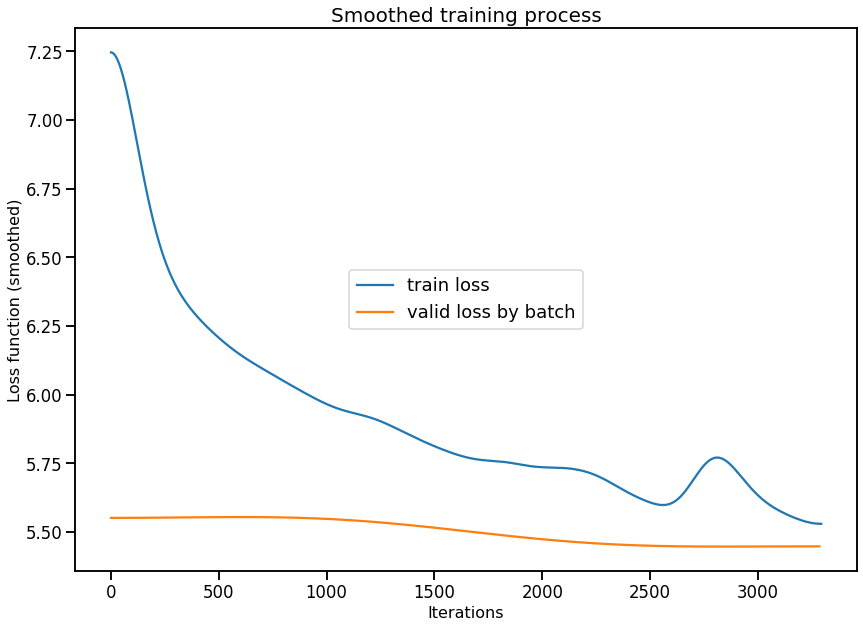

In [31]:
smooth = lambda y: gaussian_filter1d(y, sigma=100)

plt.figure(figsize=(14, 10))
plt.plot(range(len(total_train_losses)), smooth(total_train_losses), np.array(range(len(total_valid_losses)))*(len(total_train_losses)/len(total_valid_losses)), smooth(total_valid_losses))
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('Smoothed training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function (smoothed)', fontsize=16)
plt.show()

In [0]:
torch.save(model.state_dict(), 'model_1.pt')

In [33]:
model_loaded = make_model(len(SRC.vocab), len(TGT.vocab), N=1, d_ff=512)
model_loaded.load_state_dict(torch.load('model_1.pt'))
model_loaded = model_loaded.to(DEVICE)
model_loaded.eval()
with torch.no_grad():
  print(model_loaded.forward(example)[0])

tensor([[-0.1298, -0.0066, -0.0386,  ..., -0.0281, -0.1911, -0.0437],
        [-0.1315, -0.0311,  0.0273,  ...,  0.0263, -0.0634, -0.0148],
        [-0.1348, -0.1452,  0.1235,  ...,  0.0024,  0.0175,  0.0093],
        ...,
        [-0.1353, -0.0604,  0.0439,  ...,  0.0262,  0.0315,  0.0539],
        [-0.1380, -0.0883,  0.0656,  ...,  0.0785,  0.0334,  0.0561],
        [-0.1293, -0.0745,  0.1090,  ...,  0.0409, -0.0137,  0.0563]],
       device='cuda:0')


## PREDICT

In [0]:
def beam_search(model, src, src_mask, max_len=10, k=5):
    memory = model.encode(src, src_mask)
    start_token = TGT.vocab.stoi["<s>"]
    end_token = TGT.vocab.stoi["</s>"]
    ys = torch.ones(1, 1).fill_(start_token).type_as(src.data)
    beam = [(ys, 0)]
    for i in range(max_len):
        candidates= []
        candidates_proba = []
        prev_prob = None
        for snt, snt_proba in beam:
            if snt[0][-1] == end_token:
                candidates.append(snt)
                candidates_proba.append(snt_proba)
            else:
                proba = model.decode(memory, src_mask, snt,
                                     subsequent_mask(snt.size(1)).type_as(src.data))
                proba = proba[0][i]
                best_k = torch.argsort(-proba)[:k].tolist()
                proba = proba.tolist()
                prev_prob = proba
                for tok in best_k:
                    candidates.append(torch.cat([snt, torch.ones(1, 1).type_as(src.data).fill_(tok)], dim=1))
                    candidates_proba.append(snt_proba + np.log(proba[tok])) 
         
        best_candidates = np.argsort(-np.array(candidates_proba))[:k]
        beam = [(candidates[j], candidates_proba[j]) for j in best_candidates]
    return beam 

In [88]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(valid_iter):
        src = batch.src[:1]
        src_key_padding_mask = src != pad_idx
        beam = beam_search(model, src, src_key_padding_mask, max_len=8, k=5)
        
        seq = []
        for i in range(1, src.size(1)):
            sym = SRC.vocab.itos[src[0, i]]
            if sym == eos: break
            seq.append(sym)
        seq = tok_ru.decode_pieces(seq)
        print("\nSource:", seq)
        
        print("Translation:")
        for pred, pred_proba in beam:                
            seq = []
            for i in range(1, pred.size(1)):
                sym = TGT.vocab.itos[pred[0, i]]
                if sym == eos: break
                seq.append(sym)
            seq = tok_en.decode_pieces(seq)
            print(f"pred {pred_proba:.2f}:", seq)
                
        seq = []
        for i in range(1, batch.tgt.size(1)):
            sym = TGT.vocab.itos[batch.tgt[0, i]]
            if sym == eos: break
            seq.append(sym)
        seq = tok_en.decode_pieces(seq)
        print("Target:", seq)
        break


Source: справедливость климата
Translation:
pred -8.79: into developing debt chinese ira after lead developing
pred -8.80: into developing debt chinese ira after lead lead
pred -8.92: into developing debt chinese ira after lead efforts
pred -8.95: into developing debt chinese ira after lead chinese
pred -8.97: into developing debt chinese ago chinese ira private
Target: climate justice


### BLEU

In [0]:
len_test = len(list(iter(test_iter)))

In [81]:
hypotheses = []
references = []

model.eval()
with torch.no_grad():
    for batch in tqdm_notebook(test_iter, total=len_test, desc=f"Test: ", leave=True):
        for j, el in enumerate(batch.src):
            src = batch.src[j:j+1]
            src_key_padding_mask = src != pad_idx
            beam = beam_search(model, src, src_key_padding_mask, max_len=10, k=10)
            for pred, pred_proba in beam[:1]:                
                seq = []
                for i in range(1, pred.size(1)):
                    sym = TGT.vocab.itos[pred[0, i]]
                    if sym == eos: break
                    seq.append(sym)
                seq = tok_en.decode_pieces(seq)
                trg = batch.tgt[j:j+1].tolist()[0]
                ref = []
                for i, se in enumerate(trg):
                     tok = TGT.vocab.itos[trg[i]]
                     if tok == pad: break
                     ref.append(tok)
                hypotheses.append(seq.split())
                references.append(tok_en.decode_pieces(ref).split())

In [87]:
a = bleu(references, hypotheses, 
     smoothing_function=translate.bleu_score.SmoothingFunction().method3,
     auto_reweigh=True)

print(a)

0.050278
